# A simple tutorial on running AdRoit

In this tutorial, we will demonstrate how to use AdRoit to estimate the cell type proportions with single cell data as reference. 
We will use the PBMC 3k data produced by 10x Genomics (same one used in Seurat tutorial). This data contains cells from a single donor. 
To demonstrate the power of AdRoit in deconvolving multiple samples,  we will sample cells to and pool them to simulate multiple bulk samples.

In [1]:
library(AdRoit)
library(Seurat)
library(dplyr)
library(patchwork)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### 0. Download exmaple PBMC 3k single cell from 10x Genomics

In [2]:
system("wget https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz")
system("tar -xzvf filtered_gene_bc_matrices.tar.gz")

### 1. Run basic single cell analysis with Seurat

In [3]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "./filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [4]:
# Run basic single cell data processing
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
pbmc <- ScaleData(pbmc, verbose = F)
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc), verbose = F)
pbmc <- FindNeighbors(pbmc, dims = 1:10, verbose = F)
pbmc <- FindClusters(pbmc, resolution = 0.5, verbose = F)
pbmc <- RunUMAP(pbmc, dims = 1:10, verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


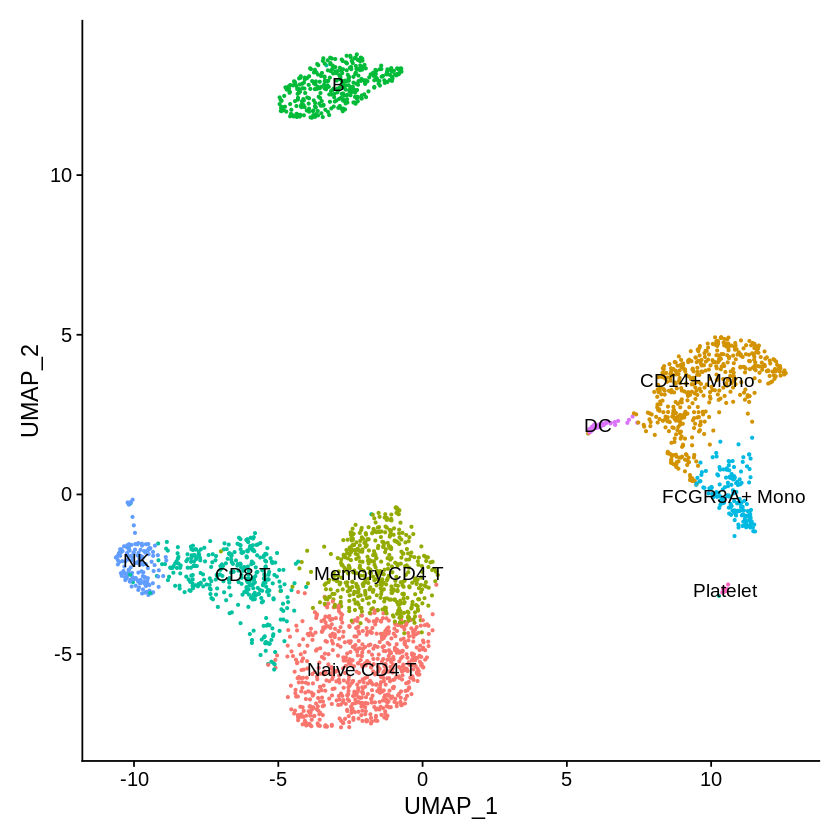

In [5]:
# Annotate cells with externally defined cell types
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [6]:
# Get markers for each cell type
pbmc.markers <- FindAllMarkers(pbmc)

Calculating cluster Naive CD4 T

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster CD14+ Mono

Calculating cluster Memory CD4 T

Calculating cluster B

Calculating cluster CD8 T

Calculating cluster FCGR3A+ Mono

Calculating cluster NK

Calculating cluster DC

Calculating cluster Platelet



It is advised to use the default setup for finding markers. The next step will do filtering based on the statistics computed.

### 2. Infer cell type proprotions with AdRoit

#### 2.1 select informative genes 

In [7]:
# select top markers from each cell type with mitochondria genes filtered out
mito.genes = grep("^MT-", rownames(pbmc), value = T)
sel.markers = pbmc.markers %>% 
                group_by(cluster) %>% 
                top_n(200, avg_log2FC) %>% 
                filter(p_val < 0.01 & !(gene %in% mito.genes))

# combine genes from every cluster, these genes are thought to be informative for cell types
info.gene = unique(sel.markers$gene)

#### 2.2 Build reference with single cell counts, cell type annotation and informative genes

In [8]:
pbmc.ref = ref.build(counts = pbmc.data, genes = info.gene, annotations = Idents(pbmc))

Estimate means and dispersions for cell type: B

Estimate means and dispersions for cell type: CD14+ Mono

Estimate means and dispersions for cell type: CD8 T

Estimate means and dispersions for cell type: DC

Estimate means and dispersions for cell type: FCGR3A+ Mono

Estimate means and dispersions for cell type: Memory CD4 T

Estimate means and dispersions for cell type: Naive CD4 T

Estimate means and dispersions for cell type: NK

Estimate means and dispersions for cell type: Platelet



The results object is a list containing three elements, the estimated means, dispersions and the cell type specificity on each gene.

#### 2.3 Simulate 5 bulk samples by sampling single cells and pool them

In [9]:
simID = sample(1:5, size = ncol(pbmc), replace = T)
sim.bulk = synthesize.bulk(counts = as.matrix(pbmc.data), annotations = Idents(pbmc), SampleID = simID)

`synthesize.bulk` generates a list, where the first element is the simulated bulk samples, second and third are the true proportions and cell count used to simulate each bulk sample.

#### 2.4 Run AdRoit estimation

In [10]:
adr.ests = AdRoit.est(bulk.sample = sim.bulk[[1]],single.ref = pbmc.ref, silent = T)

`AdRoit.est` requires input of the bulk samples, where rows are genes and columns are samples, and single cell reference estimates from `ref.build`.

Note: in real case, you shall make sure the `info.gene` set all exsit in the bulk sample. If not, you need to remove genes that are not present in the bulk sample and redo the `ref.build`.

#### 2.5 Evaluation statistics and plots

In [11]:
eval.stats = AdRoit::perform.stats(adr.ests, sim.bulk[[2]], false.cutoff = 0.0001)
eval.stats

$mAD
[1] 0.013225691 0.008163689 0.007254390 0.008449643 0.005696846

$RMSD
[1] 0.017398782 0.011315457 0.008265822 0.010094719 0.008044851

$Pearson_correlation
[1] 0.9881961 0.9910568 0.9949484 0.9943651 0.9955539

$Spearman_correlation
[1] 1.0000000 1.0000000 0.9666667 0.9833333 0.9958246

$n.FN
[1] 0 0 0 0 0

$n.FP
[1] 0 0 0 0 0

$Stats_means
        mAD        RMSD     Pearson    Spearman        n.FN        n.FP 
0.008558052 0.011023926 0.992824049 0.989164923 0.000000000 0.000000000 

$Stats_all
     mAD     RMSD  Pearson Spearman     n.FN     n.FP 
 0.00856  0.01154  0.99000  0.98710  0.00000  0.00000

Evaluation statistics: \
`mAD`: mean absolute deviation for each sample \
`RMSD`: rooted mean squared difference for each sample \
`Pearson_correlation`: Pearson correlation for each sample \
`Spearman_correlation`: Spearman correlation for each sample \
`n.FN`: number of false negative cell types based on `false.cutoff` \
`n.FP`: number of false positive cell types based on `false.cutoff` \
`Stats_means`: mean of above statistics across samples \
`Stats_all`: compute above statistics across all samples and all cell types without sample identity

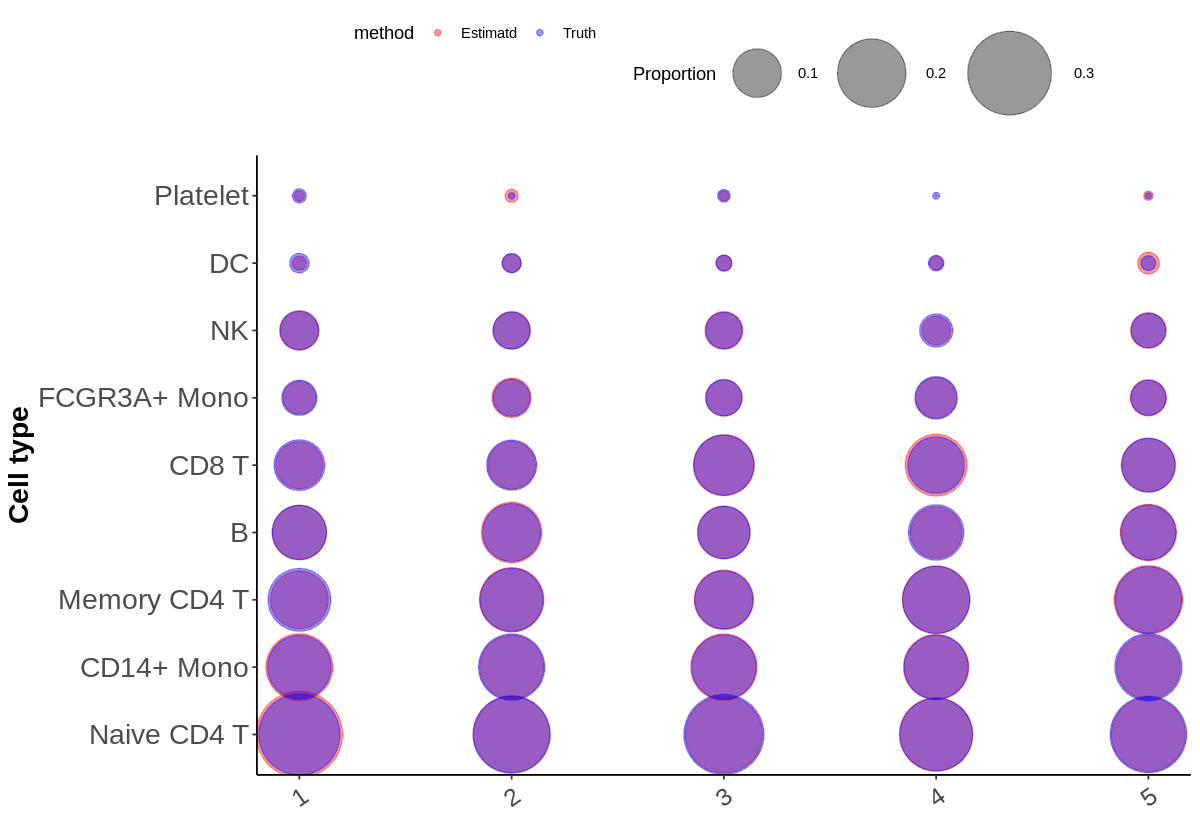

In [12]:
# Bubble plot to show how well the estimated values align with the true proprotions
options(repr.plot.height = 7, repr.plot.width = 10)
BubblePlot(prop.ests = adr.ests, prop.real = sim.bulk[[2]])

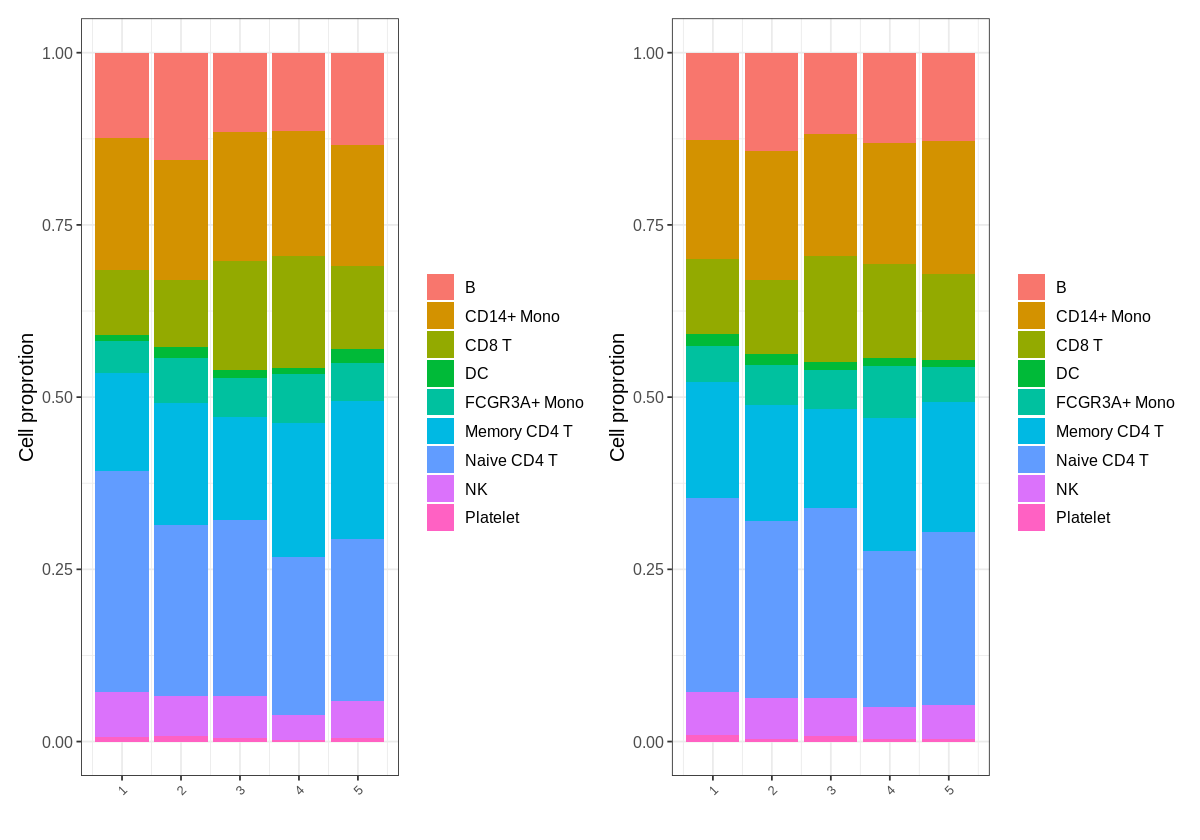

In [13]:
# Compare the true and estiamted side by side
# Estimated
p1 <- AdRoit::Proportion.Barplot(prop.ests = adr.ests)
# True
p2 <- AdRoit::Proportion.Barplot(prop.ests = sim.bulk[[2]][rownames(adr.ests), colnames(adr.ests)])
p1 + p2